In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm
import random
import torch.nn as nn
from dataset import Thyroid_Dataset
from model import Eff_Unet
from HarDMSEG import HarDMSEG
from loss_metric import DiceLoss, IOU_score, StructureLoss
from LightMed.model.LightMed import LightMed
from PMFSNet.lib.models.PMFSNet import PMFSNet
from PMFSNet.lib.models.PMFSNet_FFT import PMFSNet_FFT
import torchvision.transforms.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as tx

In [17]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms.functional as tx
import random
import cv2
from PIL import ImageEnhance
from skimage.exposure import match_histograms
import torchvision.transforms as T
import torchvision.transforms.functional as F
class GT_Thyroid_Dataset(Dataset):
    def __init__(self, csv_file, transform, image_size):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.image_size = image_size
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_name = self.df["image_name"][idx]
        mask_name = self.df["mask_name"][idx]
        image_type = self.df["image_type"][idx]

        if image_type == "train":
            from_folder = "../gt_data/train"
        else:
            from_folder = "../gt_data/test"

        image_path = f"{from_folder}/images/{image_name}"
        mask_path = f"{from_folder}/masks/{mask_name}"

        image = Image.open(image_path).convert("L")
        mask = Image.open(mask_path).convert("L")
        
        image_tensor, mask_tensor = self.transform(image, mask, self.image_size)
        mask_tensor = (mask_tensor > 0.5).float()

        return image_tensor, mask_tensor, mask_name, image_type

In [18]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [23]:
image_size = 128
batch_size = 64
def test_augmentation(image, mask, image_size):
    resize = T.Resize((image_size, image_size))
    image = resize(image)
    mask = resize(mask)

    image_tensor = tx.to_tensor(image)
    mask_tensor = tx.to_tensor(mask)

    # If standardization
    mean = image_tensor.mean()
    std = image_tensor.std()
    std = std if std > 0 else 1.0  # avoid division by zero
    image_tensor = (image_tensor - mean) / std
    return image_tensor, mask_tensor

test_dataset = GT_Thyroid_Dataset("../gt_data/all_data.csv", transform = test_augmentation, image_size = image_size)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True)

image, mask, mask_name, image_type = next(iter(test_dataloader))

In [24]:
print("std : ", torch.std(image))
print("unique : ", torch.unique(mask))

std :  tensor(1.0000)
unique :  tensor([0., 1.])


video_000049_1728635018038.MP4#t=3.066667.png
train


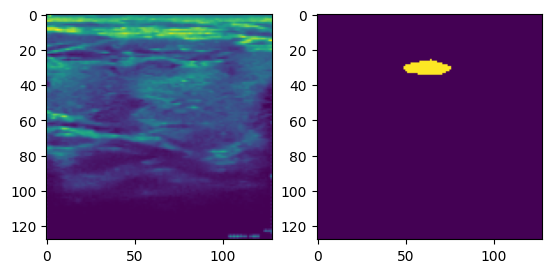

video_000090_174159851942919.png
test


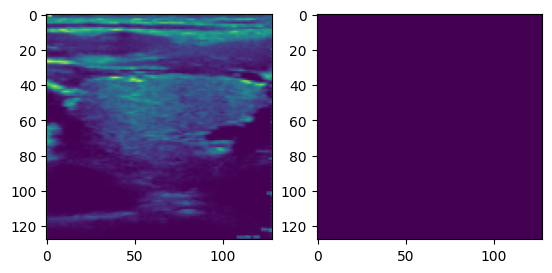

video_000050_1729236450121.mp4#t=7.6.png
train


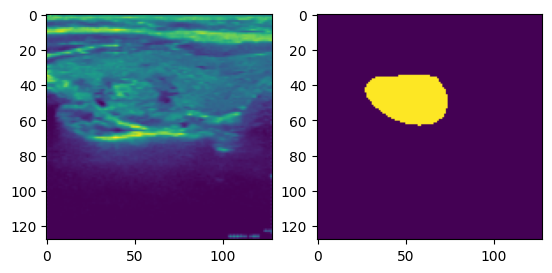

video_000049_1728636831368.MP4#t=1.866667.png
train


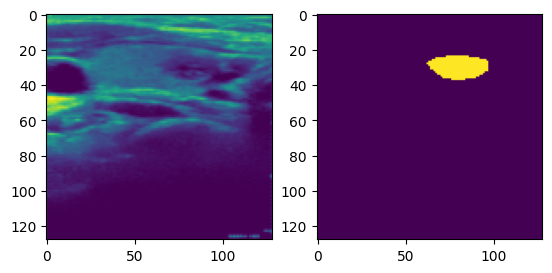

video_000049_1728636841796.MP4#t=4.8.png
train


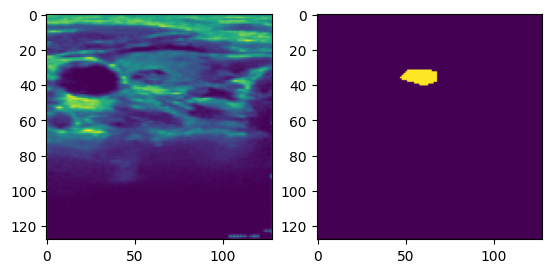

video_000049_1728632520369.MP4#t=2.266667.png
train


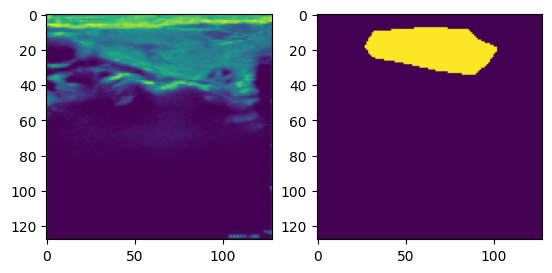

video_000049_1728636831368.MP4#t=2.466667.png
train


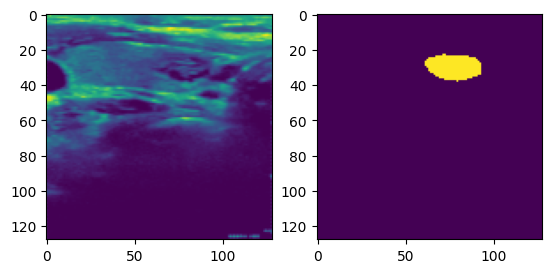

video_000041_1734084405146.mp4#t=9.266667.png
train


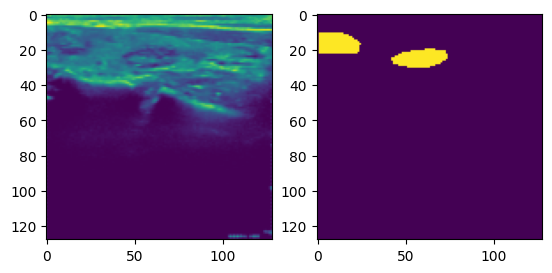

video_000058_1729844797982.mp4#t=9.6.png
test


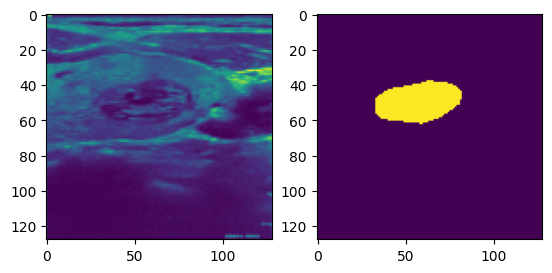

video_000055_1729840320334.mp4#t=4.933333.png
test


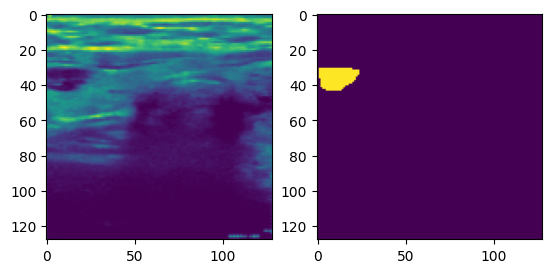

video_000050_1729237424883.mp4#t=3.333333.png
train


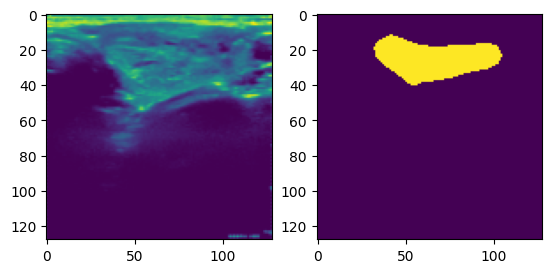

video_000050_1729240382068.mp4#t=9.2.png
train


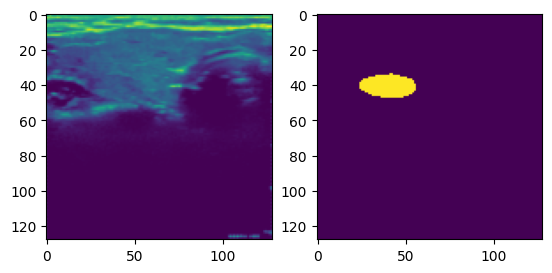

video_000035_1731051875908.mp4#t=5.6.png
train


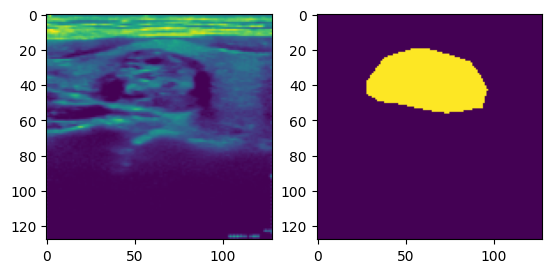

video_000050_1729238778510.mp4#t=3.466667.png
train


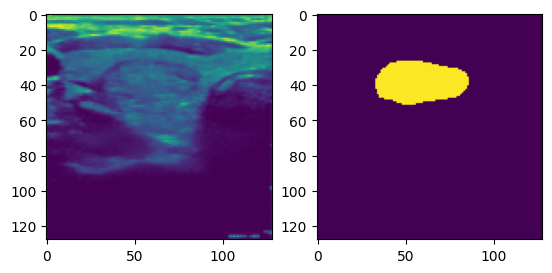

video_000049_1728635556554.mov#t=4.4.png
train


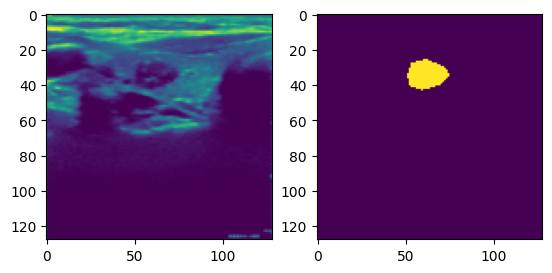

video_000049_1728636831368.MP4#t=0.866667.png
train


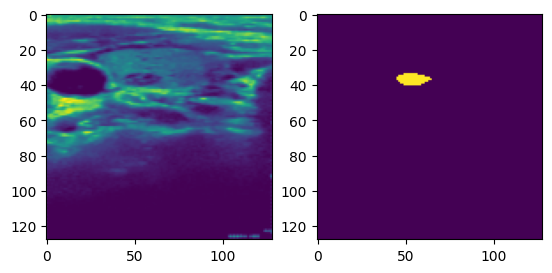

video_000055_1729840320334.mp4#t=6.866667.png
test


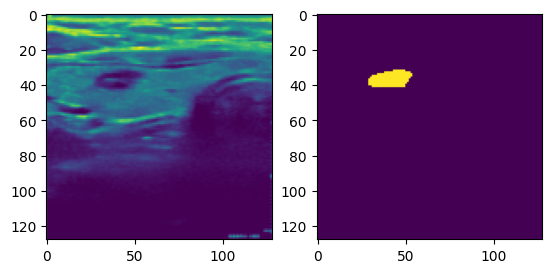

video_000050_1729241664071.mp4#t=6.2.png
train


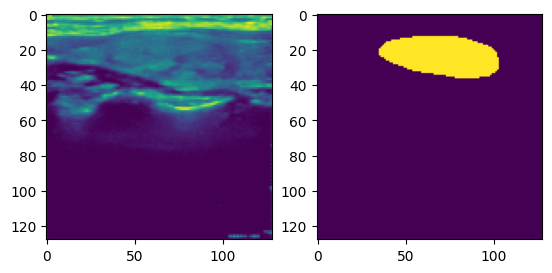

video_000049_1728631706895.MP4#t=4.933333.png
train


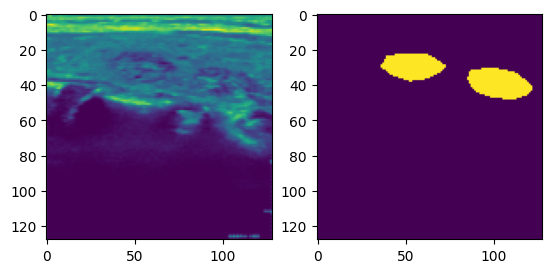

video_000050_1729236466431.mp4#t=7.4.png
train


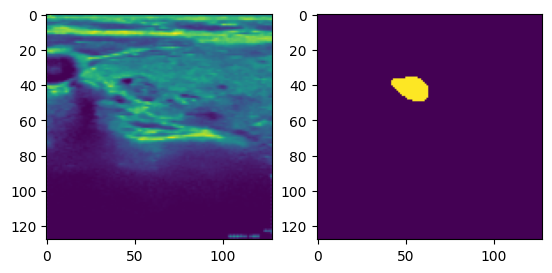

In [27]:
for i in range(20):
    print(mask_name[i])
    print(image_type[i])
    plt.subplot(1,2,1)
    plt.imshow(image[i][0])
    plt.subplot(1,2,2)
    plt.imshow(mask[i][0])
    plt.show()
    

In [28]:
# inference_name = "PMFSNet_crop_DDTI_standardization_aug_affine(0.5)_lr_0.005"
inference_name = "HarDnetMSEG_baseline"
model = HarDMSEG(in_channels = 1, out_channels = 2)
# model = PMFSNet(in_channels = 1, out_channels = 2, dim = "2d")
# model = PMFSNet_FFT(in_channels = 1, out_channels = 2, dim = "2d")
# model = LightMed(in_channels = 1, out_channels = 1, image_size = image_size)
checkpoint = torch.load(f"models/{inference_name}/best_checkpoint.pth")
model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

68 LOADED


FileNotFoundError: [Errno 2] No such file or directory: 'models/HarDnetMSEG_baseline/best_checkpoint.pth'

In [11]:
# Only calculate nodule loss, IOU, DICE, because there is no gland data in the testing set
def val(dataloader, model, loss_fn, device):
    total_loss = 0
    
    total_IOU = 0
    
    total_DICE = 0

    model.eval()
    model.to(device)
    for image, mask, mask_name, image_type in tqdm(dataloader):
        image, mask = image.to(device), mask.to(device)
        outputs = model(image)
        
        output = outputs[:, 0, :, :]
        
        
        nodule_loss = loss_fn(output, mask)

        
        IOU = IOU_score(nodule_output, nodule_mask)


        dice_loss = DiceLoss()
        DICE = 1 - dice_loss(nodule_output, nodule_mask)
    

        total_loss += nodule_loss.item()
        
        total_IOU += IOU.item()
        
        total_DICE += DICE.item()
    return total_loss/len(dataloader), total_IOU/len(dataloader), total_DICE/len(dataloader), DDTI_total_loss/len(dataloader), DDTI_total_IOU/len(dataloader), DDTI_total_DICE/len(dataloader), TN3K_total_loss/len(dataloader), TN3K_total_IOU/len(dataloader), TN3K_total_DICE/len(dataloader), 

In [12]:
# inference_name = "PMFSNet_crop_DDTI_standardization_aug_affine(0.5)_lr_0.005"
inference_name = "HarDnetMSEG_baseline"
model = HarDMSEG(in_channels = 1, out_channels = 2)
# model = PMFSNet(in_channels = 1, out_channels = 2, dim = "2d")
# model = PMFSNet_FFT(in_channels = 1, out_channels = 2, dim = "2d")
# model = LightMed(in_channels = 1, out_channels = 1, image_size = image_size)
checkpoint = torch.load(f"models/{inference_name}/best_checkpoint.pth")
model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

68 LOADED


<All keys matched successfully>

In [13]:
loss_fn_nodule = StructureLoss()
loss_fn_gland = StructureLoss()
total_loss_val, total_IOU_val, total_DICE_val, DDTI_total_loss_val, DDTI_total_IOU_val, DDTI_total_DICE_val, TN3K_total_loss_val, TN3K_total_IOU_val, TN3K_total_DICE_val = val(test_dataloader, model, loss_fn_nodule, loss_fn_gland, "cpu")
print(f"val loss : {total_loss_val}, val IOU : {total_IOU_val}, val DICE : {total_DICE_val}")
print(f"DDTI val loss : {DDTI_total_loss_val}, DDTI val IOU : {DDTI_total_IOU_val}, DDTI val DICE : {DDTI_total_DICE_val}")
print(f"TN3K val loss : {TN3K_total_loss_val}, TN3K val IOU : {TN3K_total_IOU_val}, TN3K val DICE : {TN3K_total_DICE_val}")

C:\Users\oplab\anaconda3\envs\thyroid\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))

00%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:18<00:00,  1.06it/s]

val loss : 0.6679411783814431, val IOU : 0.7551503747701644, val DICE : 0.8611435741186142
DDTI val loss : 1.260192808508873, DDTI val IOU : 0.5520977392792702, DDTI val DICE : 0.7140870273113251
TN3K val loss : 0.057885083742439745, TN3K val IOU : 0.9629108279943466, TN3K val DICE : 0.9850668966770172


In [14]:
print("ll")


ll


In [15]:
# image, mask, seg_type, from_dataset = next(iter(test_dataloader))
model.to("cpu")
outputs = model(image)
print(outputs.shape)

torch.Size([64, 2, 128, 128])


In [16]:
from_dataset

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 3,
        3, 3, 1, 3, 1, 3, 3, 1, 3, 3, 3, 1, 1, 1, 3, 1, 1, 3, 3, 3, 3, 3, 1, 3,
        1, 1, 1, 1, 1, 3, 3, 3, 1, 1, 1, 1, 3, 1, 1, 3])

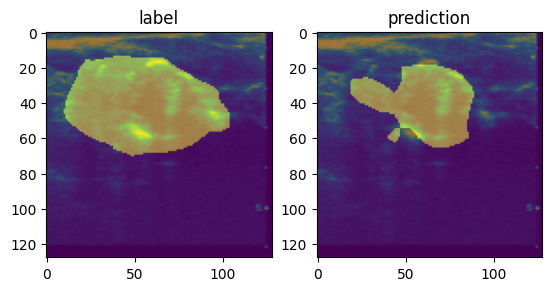

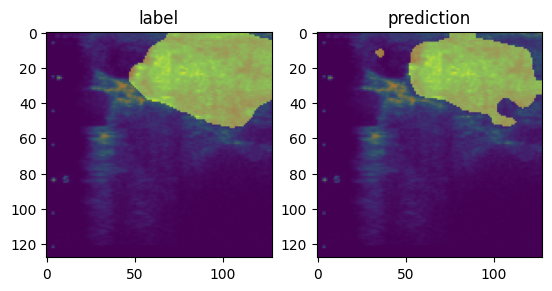

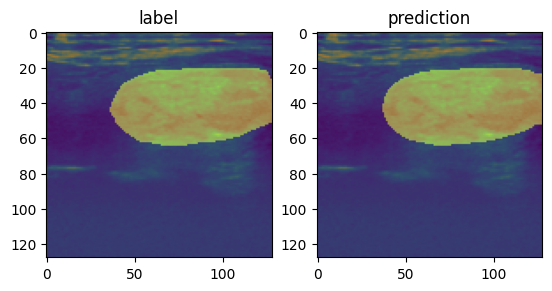

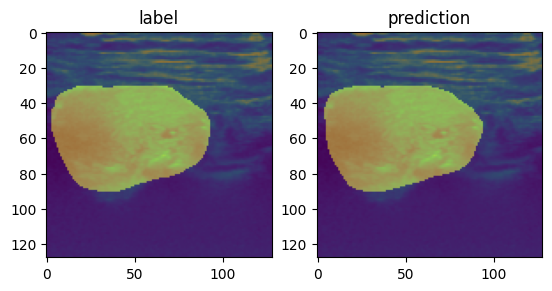

In [17]:
indexs = [9, 15, 2, 8]
for index in indexs:
    
    plt.subplot(1,2,1)
    plt.imshow(image[index][0])
    plt.imshow(mask[index][0], alpha = 0.5)
    plt.title("label")
    
    outputs = outputs>0.5
    plt.subplot(1,2,2)
    plt.imshow(image[index][0])
    plt.imshow(outputs[index][0].detach().cpu().numpy(), alpha = 0.5)
    plt.title("prediction")
    plt.show()

In [ ]:
image.shape

In [ ]:
from_dataset.shape

In [15]:
DDTI_area_ratio = []
TN3K_area_ratio = []
DDTI_image_mean = []
TN3K_image_mean = []
for image, mask, seg_type, from_dataset in tqdm(test_dataloader):
    for i in range(image.shape[0]):
        if from_dataset[i]==1:
            # plt.imshow(image[i][0])
            # plt.show()
            DDTI_area_ratio.append(torch.sum(mask[i][0])/(mask.shape[2]*mask.shape[3]))
            DDTI_image_mean.append(torch.mean(image[i][0]))
        elif from_dataset[i]==3:
            TN3K_area_ratio.append(torch.sum(mask[i][0])/(mask.shape[2]*mask.shape[3]))
            TN3K_image_mean.append(torch.mean(image[i][0]))


00%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.40it/s]

In [21]:
DDTI_area_ratio = []
TN3K_area_ratio = []
DDTI_image_mean = []
TN3K_image_mean = []
DDTI_image_std = []
TN3K_image_std = []
for image, mask, seg_type, from_dataset in tqdm(test_dataloader):
    for i in range(image.shape[0]):
        if from_dataset[i]==1:
            # plt.imshow(image[i][0])
            # plt.show()
            DDTI_area_ratio.append(torch.sum(mask[i][0])/(mask.shape[2]*mask.shape[3]))
            DDTI_image_mean.append(torch.mean(image[i][0]))
            DDTI_image_std.append(torch.std(image[i][0]))
        elif from_dataset[i]==3:
            TN3K_area_ratio.append(torch.sum(mask[i][0])/(mask.shape[2]*mask.shape[3]))
            TN3K_image_mean.append(torch.mean(image[i][0]))
            TN3K_image_std.append(torch.std(image[i][0]))


00%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.60it/s]

In [22]:
np.mean(DDTI_image_std)

0.2088157

In [23]:
np.mean(TN3K_image_std)

0.16833934

In [17]:
DDTI_image_std

[]

In [ ]:
np.mean(DDTI_area_ratio)

In [ ]:
np.mean(TN3K_area_ratio)

In [10]:
np.std(DDTI_image_mean)

0.036692772

In [11]:
np.std(TN3K_image_mean)

0.10103502